In [28]:
# %pip install google-generativeai
# %pip install pandas
# %pip install scikit-learn
# %pip install spacy
# %pip install numpy
# %pip install dotenv
# %pip install torch
# %pip install transformers

In [29]:
import requests

# URL for Chromosome 1 in FASTA format
url = 'ftp://ftp.ensembl.org/pub/release-105/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.1.fa.gz'

# Download the file
!curl {url} --output chromosome1.fa.gz

# Unzip the file
!gunzip chromosome1.fa.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100 66.0M  100 66.0M    0     0  15.4M      0  0:00:04  0:00:04 --:--:-- 15.5M
chromosome1.fa already exists -- do you wish to overwrite (y or n)? 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C


In [33]:
# Read the genome sequence from the FASTA file
with open('chromosome1.fa', 'r') as file:
    # Skip the header line
    next(file)
    # Read the sequence data
    genome_sequence = file.read().replace('\n', '')

token_count = len(genome_sequence)
print(f"Total nucleotides (tokens): {token_count}")

Total nucleotides (tokens): 248956422


In [34]:
import os
from dotenv import load_dotenv
import google.generativeai as genai

# Load environment variables from .env file
load_dotenv()

# Configure API key from environment variable
api_key = os.getenv('GENAI_API_KEY')
genai.configure(api_key=api_key)

In [35]:
# Create the model
generation_config = {
    "temperature": 0.8,
    "top_p": 0.95,
    "max_output_tokens": 5000,
}

geminiModel = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=generation_config,
)

In [36]:
# Prompt and response
# Since the sequence is too large, let's take a segment for demonstration
segment_length = 15000  # 15,000 nucleotides
genome_segment = genome_sequence[:segment_length]

# Update the prompt with the segment

prompt = f"""
You are a genomic analyst AI specializing in identifying patterns, mutations, and areas of interest in DNA sequences.

Analyze the following human genome segment from Chromosome 1 and provide insights into:

- Repetitive sequences and their significance.
- Potential gene locations and their functions.
- Common mutations or SNPs (Single Nucleotide Polymorphisms) and their associated diseases.
- Any notable patterns that could be of medical research interest.

Genome Segment:
{genome_segment}
"""

response = geminiModel.generate_content(prompt)
documentation = response.text
print("Response:\n", documentation)

Response:
 ## Analysis of Human Genome Segment from Chromosome 1

This segment appears to contain a mixture of coding and non-coding regions, with some interesting features. Let's break down the analysis:

**1. Repetitive Sequences and Significance:**

* **Alu elements:** The segment contains multiple instances of the "Alu" repetitive element, indicated by the repeated "AACCCTAACCCTAACCCT" sequences.  
* **Significance:** Alu elements are short interspersed nuclear elements (SINEs) that are abundant in the human genome. They can have a significant impact on gene regulation and expression, sometimes acting as promoters or enhancers. They can also contribute to genomic instability and disease by causing mutations.  
* **Other repetitive elements:** There are also other repetitive sequences within the segment, such as the "CCCAACCCCAACCCCA" sequence, which may be part of a different repetitive element.

**2. Potential Gene Locations and Functions:**

* **Gene prediction:**  While I cannot

In [43]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bertModel = BertModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings
def get_bert_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = bertModel(**tokens)
    return output.last_hidden_state.mean(dim=1).numpy()

# Calculate similarity using BERT embeddings
def calculate_similarity_bert(text1, text2):
    embedding1 = get_bert_embedding(text1)
    embedding2 = get_bert_embedding(text2)
    return cosine_similarity(embedding1, embedding2)[0][0]


In [44]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load spaCy model for word embeddings
nlp = spacy.load("en_core_web_sm")

# Define a function to calculate semantic similarity
def calculate_similarity(text1, text2):
    doc1 = nlp(text1)
    doc2 = nlp(text2)
    
    # Convert documents to vectors
    vector1 = doc1.vector
    vector2 = doc2.vector
    
    # Calculate cosine similarity
    similarity = cosine_similarity([vector1], [vector2])[0][0]
    return similarity

In [46]:
from collections import Counter

def keyword_coverage(prompt, response):
    prompt_words = prompt.lower().split()
    response_words = response.lower().split()
    
    prompt_word_count = Counter(prompt_words)
    response_word_count = Counter(response_words)
    
    coverage = sum(min(prompt_word_count[word], response_word_count[word]) for word in prompt_word_count) / len(prompt_words)
    return coverage

coverage_score = keyword_coverage(prompt, documentation)
print(f"Keyword Coverage Score: {coverage_score:.2f}")

Keyword Coverage Score: 0.61


In [50]:
def aggregate_coherence_score(similarity_score, coverage_score):
    # Weighted sum of different metrics
    return 0.7 * similarity_score +  0.3 * coverage_score

# Get individual scores
similarity_score = calculate_similarity_bert(prompt, documentation)
coverage_score = keyword_coverage(prompt, documentation)

# Aggregate overall coherence score
overall_coherence_score = aggregate_coherence_score(similarity_score, coverage_score)
print(f"Overall Coherence Score: {overall_coherence_score:.2f}")

Overall Coherence Score: 0.80


In [24]:
# Calculate and print the coherence score
similarity_score_bert = calculate_similarity_bert(prompt, documentation)
print(f"Coherence Score: {similarity_score_bert:.2f}")

similarity_score = calculate_similarity(prompt, documentation)
print(f"Coherence Score: {similarity_score:.2f}")

# Set a threshold for coherence (you can adjust this based on experimentation)
threshold = 0.7
if similarity_score >= threshold:
    print("The response is coherent with the prompt.")
else:
    print("The response may lack coherence with the prompt. Consider reviewing the output.")

Coherence Score: 0.89
Coherence Score: 0.75
The response is coherent with the prompt.


In [11]:
# Prompt and response
prompt = "Explain the concept of reinforcement learning."
response = geminiModel.generate_content(prompt)
documentation = response.text
print("Response:\n", documentation)

# Calculate and print the coherence score
similarity_score = calculate_similarity_bert(prompt, documentation)
print(f"Coherence Score: {similarity_score:.2f}")

# Set a threshold for coherence (you can adjust this based on experimentation)
threshold = 0.7
if similarity_score >= threshold:
    print("The response is coherent with the prompt.")
else:
    print("The response may lack coherence with the prompt. Consider reviewing the output.")


Response:
 ## Reinforcement Learning: Learning by Doing

Reinforcement learning (RL) is a type of machine learning where an **agent** learns to interact with its **environment** to achieve a **goal**. This learning process is achieved by receiving **rewards** for taking actions that lead to desired outcomes and **penalties** for taking actions that lead to undesirable outcomes. 

Think of it like training a dog. You give the dog a treat (reward) when it performs a desired action, like sitting. You might scold the dog (penalty) if it jumps on the couch. Through this process of trial and error, the dog learns to associate certain actions with rewards and others with penalties, leading to desired behavior.

Here's a breakdown of key concepts:

**1. Agent:** This is the learner, the AI system that interacts with the environment. It can be anything from a robot to a software program.

**2. Environment:** This is the world the agent operates in. It can be a physical space, a simulated world,

In [ ]:
print("Response:\n", documentation)

# Calculate and print the coherence score
similarity_score = calculate_similarity_bert(prompt, documentation)
print(f"Coherence Score: {similarity_score:.2f}")

# Set a threshold for coherence (you can adjust this based on experimentation)
threshold = 0.7
if similarity_score >= threshold:
    print("The response is coherent with the prompt.")
else:
    print("The response may lack coherence with the prompt. Consider reviewing the output.")


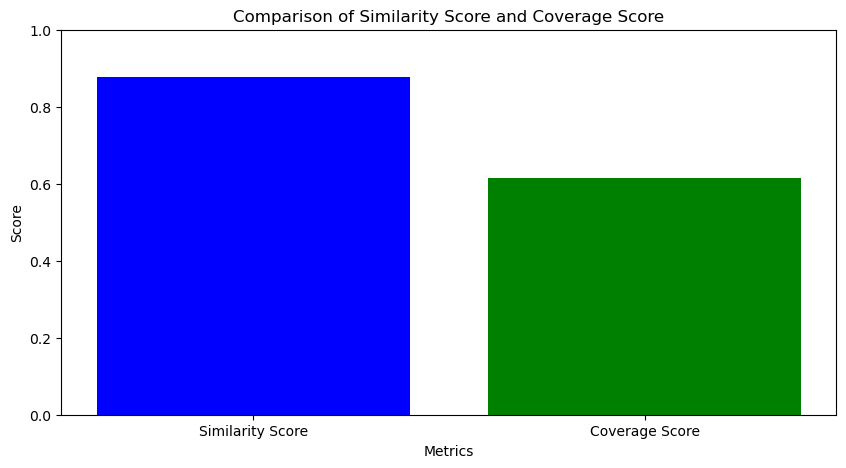

In [54]:
import matplotlib.pyplot as plt

# Plot the similarity score and coverage score
plt.figure(figsize=(10, 5))
plt.bar(['Similarity Score', 'Coverage Score'], [similarity_score, coverage_score], color=['blue', 'green'])
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Similarity Score and Coverage Score')
plt.show()
